# Phase Estimation with Quantum Exponential Least Squares (QCELS)

arXiv:2211.11973

Here the scipy implementation lives. 

Please try to implement with a cicuit using pytket

# Generate Hamiltonian
- Ising Model

In [1]:
from hamiltonians import ising_model
qubit_ham = ising_model(4, 1.0, 0.5)

## Exact GS
- Perfect input to algorithm for testing

In [2]:
import numpy
qubit_ham_mat = qubit_ham.to_sparse_matrix().todense()
e,c = numpy.linalg.eigh(qubit_ham_mat)
gs_735 = c[:,0]

## Bad Initial State
- streched H2
- Will be used as the non perfect input

In [17]:
gs_bad = 0.9*c[:,0] + 0.2*c[:,5]

# Transition Matrix Elements
- Scipy makes this easy
- Can be done with X and Y measurements via the hadamard test

In [18]:
from scipy.linalg import expm
def transition_element(gs,h,t):
    result = (gs.conj().T @ expm(-1j*t*h) @ gs).item()
    return result.real, result.imag, result

## Calculate Transition Matrix Elements
- $ \langle \psi| e^{-iHn\tau} |\psi\rangle $
- For a range of $\tau $

In [19]:
from matplotlib import axis
import pandas as pd
time_end = 10
n_time_steps = 100
tau = time_end/n_time_steps
results_dict_gs = {time: transition_element(gs_735, qubit_ham_mat, time) for time in numpy.linspace(0, time_end, n_time_steps)}
df_gs = pd.DataFrame.from_dict(results_dict_gs, orient='index', columns=['real','imag','result']).rename_axis('t')

#Same Hamiltoninan, different initial state
bad_state = gs_bad
results_dict_badstate = {time: transition_element(bad_state, qubit_ham_mat, time) for time in numpy.linspace(0, time_end, n_time_steps)}
df_bads = pd.DataFrame.from_dict(results_dict_badstate, orient='index', columns=['real','imag','result']).rename_axis('t')

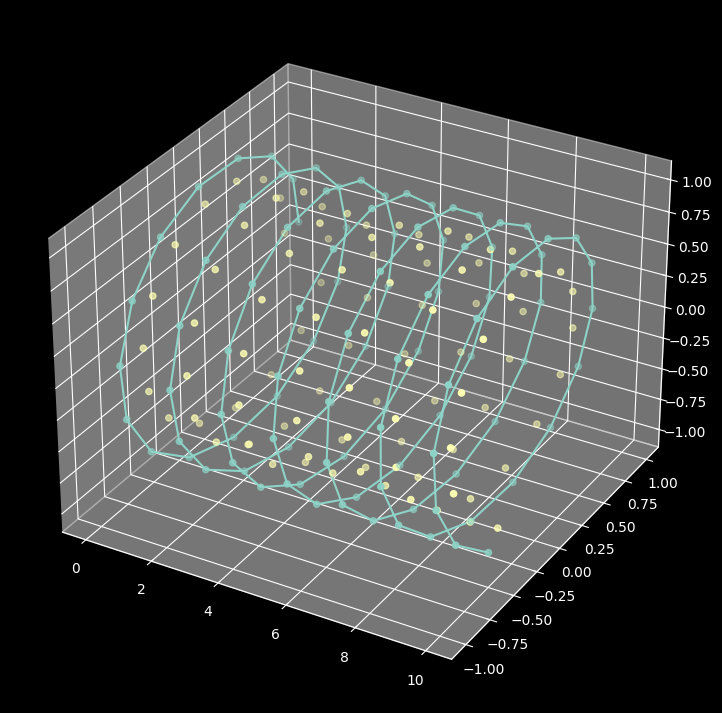

In [20]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

fig = plt.figure(figsize=(12, 9))
ax = plt.axes(projection='3d')
ax.plot3D(df_gs.index.to_numpy(),df_gs.real,df_gs.imag)
# ax.plot3D(df_bads.index.to_numpy(),df_bads.real,df_bads.imag)
ax.scatter(df_gs.index.to_numpy(),df_gs.real,df_gs.imag)
ax.scatter(df_bads.index.to_numpy(),df_bads.real,df_bads.imag)



## Optimisation Function

$ f(\theta) = \Big|\sum_{n=0}^{N-1} Z_n e^{i\theta n \tau}\Big|^2 $



In [21]:
def f_theta(tau, df):
    def f_theta_fun(theta):
        return abs(sum([res * (numpy.exp(1j*tau*theta*n)) for n,res in enumerate(df.result.to_list())]))
    return f_theta_fun

## Exact GS
- Peak at exact eigenstate
- Need an algorithm to extract maximum
- Presented here arXiv:2211.11973

<Axes: xlabel='theta'>

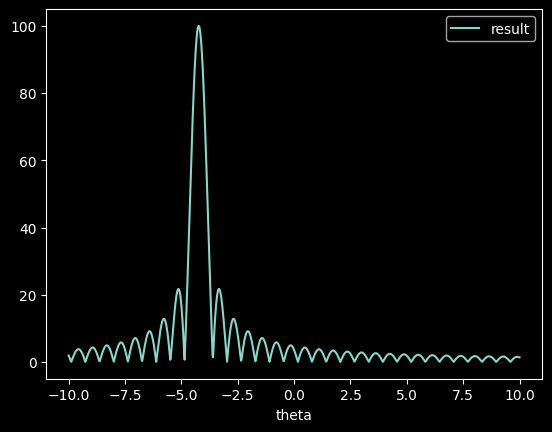

In [22]:
objective_function = f_theta(tau, df_gs)
x_range = numpy.linspace(-10, 10, 1000)
results_df = pd.DataFrame.from_dict({theta: objective_function(theta) for theta in x_range}, orient='index', columns=['result']).rename_axis('theta')
results_df.plot()

## Bad GS
- Still pretty good
- Other eigenstates present

<Axes: xlabel='theta'>

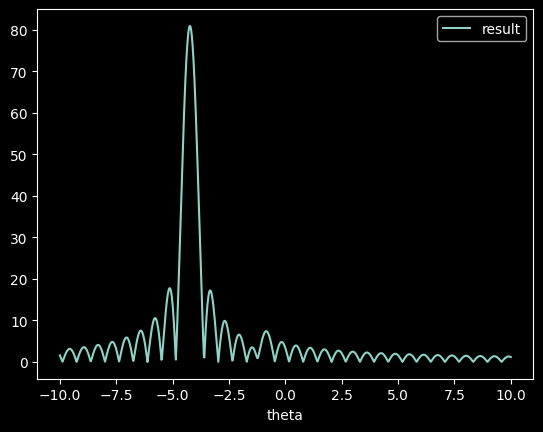

In [23]:
objective_function = f_theta(tau, df_bads)
results_df = pd.DataFrame.from_dict({theta: objective_function(theta) for theta in x_range}, orient='index', columns=['result']).rename_axis('theta')
results_df.plot()